In [48]:
import sys
import logging
import pathlib
from typing import Optional
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

from copairs import map, compute
from pycytominer import feature_select
# from cytominer_eval import evaluate_metrics

# imports src
sys.path.append("../")
from src import utils

# setting up logger
logging.basicConfig(
    filename="map_analysis_testing.log",
    level=logging.DEBUG,
    format="%(levelname)s:%(asctime)s:%(name)s:%(message)s",
)


from matplotlib import font_manager
font_path = '../../open-sans/OpenSans-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams["font.family"] = ["Open Sans"]
plt.rcParams["font.size"] = 16

In [49]:
def x_axis_formatter(x, pos, n_labels=5):
    if pos == 1 or pos == n_labels - 1:
        return f'{int(x)}'  # Format the first tick label as '0' without decimals
    else:
        return f'{x:.2f}'  # Use general format for other labels

def plot_map_x3(df, col, title, row=None, move_legend="lower right",
                aspect=None, adjust=None, s=50, pr_x=0.61, pr_y=0.35, l_x=1.05, l_y=0.575, m_x=0.52, m_y=0.01):
    
    unique_col_values = df[col].unique()
    num_cols = len(unique_col_values)
    num_rows = 1
    unique_row_values = [None]

    if row is not None and row in df.columns:
        unique_row_values = df[row].unique()
        num_rows = len(unique_row_values)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), layout='constrained', sharex=True, sharey=True)

    # Adjust for single subplot to avoid indexing error
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])  # Make it 2D for consistent indexing
    elif num_rows == 1 or num_cols == 1:
        axes = np.array([axes])  # Wrap in another array for consistent indexing

    for row_i, row_value in enumerate(unique_row_values):

        row_df = df[df[row] == row_value] if row is not None else df
        row_axes = axes[row_i] if num_rows > 1 else axes[0]

        for col_i, col_value in enumerate(unique_col_values):
            sub_df = row_df[row_df[col] == col_value]
            mean_map = sub_df['AP'].mean()
            fr = sub_df['p < 0.05'].mean()

            ax_scatter = row_axes[col_i] if num_cols > 1 else row_axes[0]  # Adjust for single column
            if aspect is not None:
                ax_scatter.set(aspect=aspect)
            ax_kde = ax_scatter.inset_axes([0, 1, 1, 0.15], sharex=ax_scatter)
            
            sns.scatterplot(
                ax=ax_scatter,
                data=sub_df, 
                x='AP', 
                y='-log10(AP p-value)', 
                hue='p < 0.05',
                s=s
            )
            ax_scatter.set_xlabel("")
            ax_scatter.set_xlim(-0.05, 1.05)
            ax_scatter.set_ylim(-0.1, max(sub_df['-log10(AP p-value)'])+0.25)
            ax_scatter.xaxis.set_major_locator(MultipleLocator(base=0.25))
            ax_scatter.get_xaxis().set_major_formatter(FuncFormatter(partial(x_axis_formatter, n_labels=6)))

            ax_scatter.set_title(f"{col_value}", fontsize=16, pad=20)

            ## Specific for Fig 3A
            # ax_scatter.set_ylabel(f"Preprocessing: {row_value}\n-log10(mAP p-value)")
            
            if col_i == 1:
                ax_scatter.text(pr_x, 0.02, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
            else:
                ax_scatter.text(pr_x, pr_y, f"Retrieved: {fr:.0%}", transform=ax_scatter.transAxes)
            
            # if col_i == num_cols - 1 and row_i == 0:
            #     sns.move_legend(ax_scatter, "upper left", bbox_to_anchor=(1., .5), frameon=False)
            # else:
            #     ax_scatter.get_legend().remove()
            handles, labels = ax_scatter.get_legend_handles_labels()
            ax_scatter.get_legend().remove()

            max_kde_y = 0
            for p_value in sorted(sub_df['p < 0.05'].unique()):
                sns.kdeplot(
                    ax=ax_kde,
                    data=sub_df[sub_df['p < 0.05'] == p_value],
                    x='AP', 
                    label=str(p_value)
                )
                max_kde_y = max(max_kde_y, max(ax_kde.lines[-1].get_ydata()))

            ax_kde.axvline(mean_map, color='grey', linestyle='--')
            if mean_map < 0.5:
                ax_kde.text(mean_map + 0.05, 0.7, f"mAP: {mean_map:.2f}", transform=ax_kde.transAxes)
            else:
                ax_kde.text(mean_map - 0.2, 0.7, f"mAP: {mean_map:.2f}", transform=ax_kde.transAxes)

            ax_kde.get_yaxis().set_visible(False)
            ax_kde.get_xaxis().set_visible(False)
            sns.despine(ax=ax_kde, left=True, bottom=True)

    fig.text(m_x, m_y, 'AP', ha='center', va='center')

    plt.tight_layout()
    fig.legend(handles, labels, title="p < 0.05", loc="upper center", bbox_to_anchor=(l_x, l_y), frameon=False)
    if adjust is not None:
        fig.subplots_adjust(**adjust)
    # fig.subplots_adjust(right=0.85)
    plt.show()

In [50]:
def p_values(dframe: pd.DataFrame, null_size: int, seed: int):
    '''Compute p-values'''
    mask = dframe['n_pos_pairs'] > 0
    pvals = np.full(len(dframe), np.nan, dtype=np.float32)
    scores = dframe.loc[mask, 'average_precision'].values
    null_confs = dframe.loc[mask, ['n_pos_pairs', 'n_total_pairs']].values
    pvals[mask] = compute.p_values(scores, null_confs, null_size, seed)
    return pvals

## Setting up Paths and loading data

In [51]:
# parameters
training_singlecell_data = pathlib.Path("../data/raw/training_data__no_ic.csv.gz").resolve(
    strict=True
)
neg_control_data = pathlib.Path(
    "../data/raw/normalized_data/negative_control_data.csv.gz"
).resolve(strict=True)

# output directories
map_out_dir = pathlib.Path("../data/processed/mAP_scores/")
map_out_dir.mkdir(parents=True, exist_ok=True)

In [52]:
training_sc_data = pd.read_csv(training_singlecell_data).drop("Unnamed: 0", axis=1)
training_sc_data.shape


(2894, 1450)

In [53]:
training_sc_data[training_sc_data.filter(regex="^(?!CP__|DP__)").columns].Mitocheck_Phenotypic_Class.value_counts()

Mitocheck_Phenotypic_Class
Interphase            419
Polylobed             361
Prometaphase          345
OutOfFocus            304
Apoptosis             276
MetaphaseAlignment    175
Binuclear             174
SmallIrregular        164
Hole                  114
Elongated             107
ADCCM                  89
Anaphase               84
Grape                  78
Large                  77
Metaphase              74
Folded                 53
Name: count, dtype: int64

<Axes: >

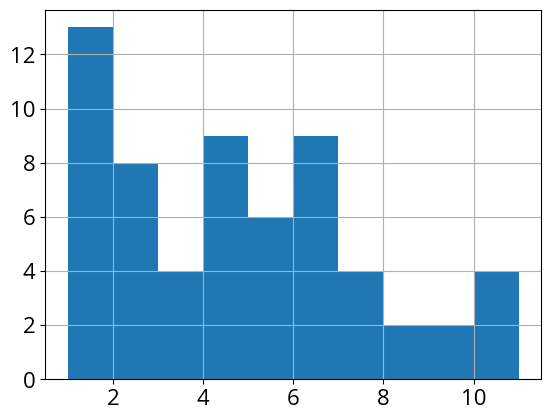

In [54]:
training_sc_data.groupby("Metadata_Gene")["Mitocheck_Phenotypic_Class"].nunique().hist()

In [55]:
# training_sc_data = pd.read_parquet("../data/processed/training_sc_data.parquet")
# neg_control_sc_data = pd.read_parquet("../data/processed/neg_control_sc_data.parquet")
training_sc_data = pd.read_csv(training_singlecell_data).drop("Unnamed: 0", axis=1)
neg_control_sc_data = pd.read_csv(neg_control_data)

# adding the Mitocheck_Phenotypic_Class into the controls  and labels
neg_control_sc_data.insert(0, "Mitocheck_Phenotypic_Class", "neg_control")

# adding control labels into the dataset
training_sc_data.insert(1, "Metadata_is_control", 0)
neg_control_sc_data.insert(1, "Metadata_is_control", 1)

# droping column from trainign data since it does not exist in the controls
training_sc_data = training_sc_data.drop("Metadata_Object_Outline", axis=1)


print("control shape:", neg_control_sc_data.shape)
print("training shape:", training_sc_data.shape)

control shape: (779993, 1450)
training shape: (2894, 1450)


In [58]:
neg_control_sc_wells = neg_control_sc_data["Metadata_Well"].unique()
neg_control_sc_wells

array([304, 315, 352, 363,  15,  26,  63,  74])

## Applying Pycytominer Selected features data

In [5]:
fs_ops = [
    'variance_threshold',
    'correlation_threshold',
    'drop_na_columns',
]

In [6]:
training_sc_data.groupby("Metadata_Gene").apply(lambda x: x.groupby(["Metadata_Plate", "Metadata_Well"]).size().shape[0]).hist()

NameError: name 'training_sc_data' is not defined

In [9]:
# applying cytominer feature selection trianing data
cp_cols = [
    colname for colname in training_sc_data.columns if colname.startswith("CP__")
]

# # extracting only CP features
train_meta, train_features = utils.split_data(training_sc_data, dataset="CP")
cp_data = pd.concat([train_meta, pd.DataFrame(train_features)], axis=1)
cp_data.columns = train_meta.columns.tolist() + cp_cols

# applying pycytominer feature select
# had to specify the feature names since the defaults did not match
pycytm_cp_training_feats_df = feature_select(cp_data, features=cp_cols)
pycytm_cp_training_feats_df = pycytm_cp_training_feats_df[
    [
        cols
        for cols in pycytm_cp_training_feats_df.columns.tolist()
        if cols.startswith("CP__")
    ]
]
del cp_data

# now update loaded dataset with pycytominer selected features to trainin dataset
# remove old CP features and added new pycytominer selected CP_features
training_sc_data = training_sc_data[
    [col for col in training_sc_data.columns.tolist() if not col.startswith("CP__")]
]
training_sc_data = pd.concat([training_sc_data, pycytm_cp_training_feats_df], axis=1)
print(f"{training_sc_data.shape=}")

training_sc_data.shape=(2894, 1433)


In [10]:
# applying cytominer feature selection negative control data
cp_cols = [
    colname for colname in neg_control_sc_data.columns if colname.startswith("CP__")
]

# extracting only CP features
neg_control_meta, neg_control_features = utils.split_data(
    neg_control_sc_data, dataset="CP"
)
cp_data = pd.concat([neg_control_meta, pd.DataFrame(neg_control_features)], axis=1)
cp_data.columns = neg_control_meta.columns.tolist() + cp_cols

# applying pycytominer feature select
# had to specify the feature names since the defaults did not match
pycytm_cp_training_feats_df = feature_select(cp_data, features=cp_cols)
pycytm_cp_training_feats_df = pycytm_cp_training_feats_df[
    [
        cols
        for cols in pycytm_cp_training_feats_df.columns.tolist()
        if cols.startswith("CP__")
    ]
]
del cp_data

# now update loaded dataset with pycytominer selected features to trainin dataset
# remove old CP features and added new pycytominer selected features
neg_control_sc_data = neg_control_sc_data[
    [col for col in neg_control_sc_data.columns.tolist() if not col.startswith("CP__")]
]
neg_control_sc_data = pd.concat(
    [neg_control_sc_data, pycytm_cp_training_feats_df], axis=1
)
print(f"{neg_control_sc_data.shape=}")

neg_control_sc_data.shape=(779993, 1395)


In [11]:
neg_control_sc_data_subset = neg_control_sc_data.sample(frac=0.005, random_state=0)
neg_control_sc_data_subset.to_parquet("../data/processed/neg_control_sc_fs_subset.parquet", index=False)
print(f"{neg_control_sc_data_subset.shape=}")
training_sc_data.to_parquet("../data/processed/training_sc_fs.parquet", index=False)
print(f"{training_sc_data.shape=}")

neg_control_sc_data_subset.shape=(3900, 1395)
training_sc_data.shape=(2894, 1433)


### mAP Pipeline Parameters

In [14]:
training_sc_data = pd.read_parquet("../data/processed/training_sc_fs.parquet")
neg_control_sc_data = pd.read_parquet("../data/processed/neg_control_sc_fs_subset.parquet")

training_sc_data["Metadata_control_index"] = -1
neg_control_sc_data["Metadata_control_index"] = neg_control_sc_data.index

print(training_sc_data.shape, neg_control_sc_data.shape)

(2894, 1434) (3900, 1396)


In [15]:
training_sc_data_dp = training_sc_data.filter(regex="^(?!CP__)")
training_sc_data_cp = training_sc_data.filter(regex="^(?!DP__)")

In [16]:
print(training_sc_data_cp.shape)
training_sc_data_cp_fs = feature_select(
    training_sc_data_cp,
    features=training_sc_data_cp.filter(regex="CP__").columns.tolist()
)
print(training_sc_data_cp_fs.shape)

(2894, 154)


(2894, 154)


In [17]:
fs_ops = [
    'variance_threshold',
    'correlation_threshold',
    'drop_na_columns',
]

print(training_sc_data_dp.shape)
training_sc_data_dp_fs = feature_select(
    training_sc_data_dp,
    features=training_sc_data_dp.filter(regex="DP__").columns.tolist(),
    operation=fs_ops,
    freq_cut=0.0001,
)
print(training_sc_data_dp_fs.shape)

(2894, 1294)
(2894, 1294)


In [18]:
all([c for c in neg_control_sc_data.columns if c in training_sc_data.columns] == neg_control_sc_data.columns)
training_sc_data = training_sc_data[neg_control_sc_data.columns]

df = pd.concat([training_sc_data, neg_control_sc_data], axis=0)
df.shape

(6794, 1396)

In [60]:
# how many unique wells are there per morphological class in the training data
training_sc_data.query("Mitocheck_Phenotypic_Class != 'OutOfFocus'").groupby("Mitocheck_Phenotypic_Class")["Metadata_Well"].nunique()

Mitocheck_Phenotypic_Class
ADCCM                  5
Anaphase              13
Apoptosis             27
Binuclear             26
Elongated             14
Folded                 9
Grape                  6
Hole                  11
Interphase            25
Large                 16
Metaphase             19
MetaphaseAlignment    22
Polylobed             35
Prometaphase          14
SmallIrregular        13
Name: Metadata_Well, dtype: int64

In [67]:
# how many single cells are there per each well - morphological class in the training data

print(training_sc_data.query("Mitocheck_Phenotypic_Class != 'OutOfFocus'").groupby(["Mitocheck_Phenotypic_Class", "Metadata_Well"]).size() == 1)


# now filter out wells per morphological class that have less than 2 single cells

counts_above_2cells = training_sc_data.query("Mitocheck_Phenotypic_Class != 'OutOfFocus'").groupby(["Mitocheck_Phenotypic_Class", "Metadata_Well"]).size().reset_index(name="counts").query("counts > 1")
print(counts_above_2cells)

# use counts_above_2cells to filter training data

training_sc_data = training_sc_data.merge(counts_above_2cells, on=["Mitocheck_Phenotypic_Class", "Metadata_Well"], how="inner")

Mitocheck_Phenotypic_Class  Metadata_Well
ADCCM                       5                 True
                            166              False
                            184              False
                            250               True
                            383              False
                                             ...  
SmallIrregular              184              False
                            245              False
                            287              False
                            292              False
                            319              False
Length: 255, dtype: bool


In [19]:
assert all(df.filter(regex="^(?!CP__|DP__)").columns == df.filter(regex="^(?!CP__|DP__)").columns)

meta_features = df.filter(regex="^(?!CP__|DP__)").columns
cp_features = df.filter(regex="^(CP__)").columns
dp_features = df.filter(regex="^(DP__)").columns
cp_dp_features = cp_features.tolist() + dp_features.tolist()

print(len(meta_features), len(cp_features), len(dp_features), len(cp_dp_features))

14 102 1280 1382


In [20]:
data_config = {
    "cp": cp_features,
    "dp": dp_features,
    "cp_dp": cp_dp_features,
}

In [21]:
# pos_sameby = ["Mitocheck_Phenotypic_Class", "Metadata_control_index"]
# pos_diffby = []

# neg_sameby = []
# neg_diffby = ["Mitocheck_Phenotypic_Class", "Metadata_control_index"]

# null_size = 10000
# batch_size = 1000

# number of resampling
# n_resamples = 10

pair_config = {
    "pos_sameby": {"all": ["Mitocheck_Phenotypic_Class", "Metadata_control_index"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Mitocheck_Phenotypic_Class", "Metadata_control_index"], "any": []},
}

map_config = {
    "mean_ap": {
        "null_size": 10000,
        "groupby_columns": ["Mitocheck_Phenotypic_Class"],
    },
}

In [22]:
df_qc = df.query("Metadata_Gene != 'failed QC' and Mitocheck_Phenotypic_Class != 'OutOfFocus'")
df_qc.shape

(6356, 1396)

In [23]:
df_qc.Mitocheck_Phenotypic_Class.value_counts()

Mitocheck_Phenotypic_Class
neg_control           3900
Interphase             409
Polylobed              351
Prometaphase           342
Apoptosis              273
Binuclear              172
SmallIrregular         164
MetaphaseAlignment     142
Hole                   114
Elongated              107
Large                   77
Grape                   77
Anaphase                74
Metaphase               65
Folded                  53
ADCCM                   36
Name: count, dtype: int64

In [24]:
ap_result = map.average_precision(
    df_qc[meta_features],
    df_qc[cp_features].values,
    pos_sameby=["Metadata_Gene", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Metadata_Gene", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


In [25]:
ap_result["p_value"] = p_values(ap_result, null_size=10000, seed=0)
ap_result["p < 0.05"] = ap_result["p_value"] < 0.05
ap_result["-log10(AP p-value)"] = - np.log10(ap_result["p_value"])
ap_result.rename(columns={"average_precision": "AP"}, inplace=True)
ap_result["Features"] = "CellProfiler"


  0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_11222/4114252858.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


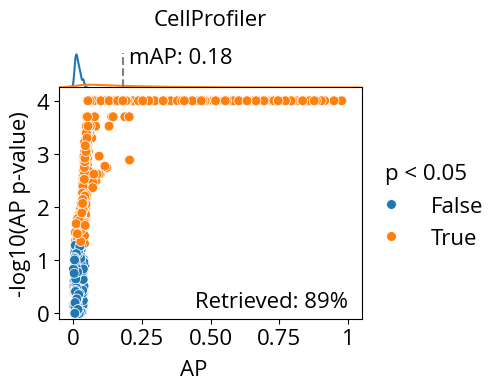

In [26]:
plot_map_x3(ap_result, "Features", "", pr_x=0.45, pr_y=0.05, l_x=1.1)

In [27]:
dp_ap_result = map.average_precision(
    df_qc[meta_features],
    df_qc[dp_features].values,
    pos_sameby=["Metadata_Gene", "Metadata_control_index"],
    pos_diffby=[],
    neg_sameby=[],
    neg_diffby=["Metadata_Gene", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


In [28]:
dp_ap_result["p_value"] = p_values(dp_ap_result, null_size=10000, seed=0)
dp_ap_result["p < 0.05"] = dp_ap_result["p_value"] < 0.05
dp_ap_result["-log10(AP p-value)"] = - np.log10(dp_ap_result["p_value"])
dp_ap_result.rename(columns={"average_precision": "AP"}, inplace=True)
dp_ap_result["Features"] = "DeepProfiler"

  0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipykernel_11222/4114252858.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


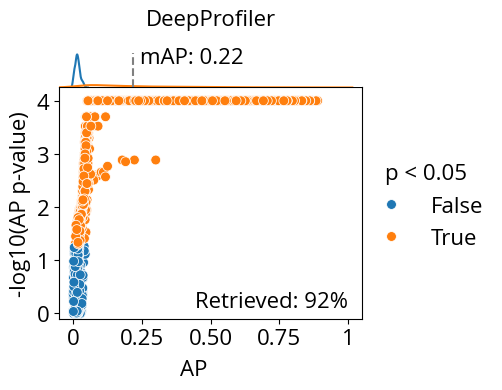

In [29]:
plot_map_x3(dp_ap_result, "Features", "", pr_x=0.45, pr_y=0.05, l_x=1.1)

In [30]:
df_qc[dp_features]

,DP__efficientnet_0,DP__efficientnet_1,DP__efficientnet_2,DP__efficientnet_3,DP__efficientnet_4,DP__efficientnet_5,DP__efficientnet_6,DP__efficientnet_7,DP__efficientnet_8,DP__efficientnet_9,...,DP__efficientnet_1270,DP__efficientnet_1271,DP__efficientnet_1272,DP__efficientnet_1273,DP__efficientnet_1274,DP__efficientnet_1275,DP__efficientnet_1276,DP__efficientnet_1277,DP__efficientnet_1278,DP__efficientnet_1279
0,0.027767,4.511479,-0.776562,2.691449,0.467958,6.727201,0.442005,1.516700,0.144210,0.477357,...,0.219501,-0.416624,-0.602064,-1.149988,-0.520968,1.292410,11.614993,0.535486,2.875145,-0.837069
1,0.715030,0.650755,-0.226738,2.717374,0.307060,2.467425,0.830731,0.642929,-0.416397,0.727912,...,-0.664476,-1.397901,-0.645742,-1.067267,-0.007235,2.299296,1.372604,1.280672,-0.541297,-1.152779
2,-1.231899,0.961342,-0.689251,0.172232,-0.334562,1.884616,-0.681420,0.431674,-0.636919,-0.190554,...,0.636564,1.402440,-0.552524,0.266396,-0.329313,0.126110,-0.322944,0.813079,-0.510780,-0.057089
3,-0.625778,1.448722,-0.848505,-0.621066,0.589192,1.259481,-0.045691,-0.373459,-1.150473,1.575146,...,-0.919341,-0.865719,-0.520659,0.222127,0.371482,2.289868,-0.133843,1.201244,-1.771245,-0.510236
4,-0.750390,1.915938,0.570107,-0.501050,0.152255,2.684823,0.175338,1.045069,1.533819,-0.624163,...,0.501800,-0.410976,-0.310428,-1.285884,-0.546935,2.795317,2.514185,0.361808,-0.322569,-0.583547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,0.434000,-0.478215,-0.843622,-0.319469,0.022545,-0.300251,0.454646,0.543173,-0.579572,0.283789,...,0.752982,7.824874,0.777362,-1.127415,-0.311682,-0.354281,0.180592,-1.906622,-0.054387,2.242351
3896,-0.631732,-1.223155,-0.016211,-0.721125,-1.552194,-0.950433,-1.079000,0.501861,0.888982,7.289269,...,0.313359,-0.490690,0.685978,-1.258323,7.643061,-0.941830,-0.680223,-2.603259,-0.572277,0.941993
3897,-0.512438,1.580393,-0.721760,-0.107497,0.322230,1.632249,-0.314991,0.411847,-0.205630,-0.049756,...,-0.094229,-0.494570,-0.593919,0.436568,-0.439173,-0.023813,-0.003510,0.478639,-0.586012,0.204341
3898,0.861760,1.337650,2.570858,-0.478438,0.400851,-0.686645,0.587346,0.556622,1.073988,0.251702,...,-0.982869,-0.579944,-0.335523,1.301493,0.082189,-0.175594,-0.268395,-0.270455,-0.576776,-0.778137


In [31]:
class_ap_result = map.average_precision(
    df_qc[meta_features],
    df_qc[cp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

class_ap_result["p_value"] = p_values(class_ap_result, null_size=10000, seed=0)
class_ap_result["p < 0.05"] = class_ap_result["p_value"] < 0.05
class_ap_result["-log10(AP p-value)"] = - np.log10(class_ap_result["p_value"])

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/14 [00:00<?, ?it/s]

In [32]:
aps = pd.DataFrame([
    ap_result["AP"],
    ap_result["p < 0.05"],
    class_ap_result["average_precision"],
    class_ap_result["p < 0.05"]
], index=["AP, Gene", "Gene p < 0.05", "AP, Morphological Class (MC)", "MC p < 0.05"]).T

In [33]:
aps["AP, Gene"].mean(), aps["AP, Morphological Class (MC)"].mean()

(0.1822692873809557, 0.4182801152695942)

In [34]:
aps['Gene p < 0.05'].mean(), aps['MC p < 0.05'].mean()

(0.8908794788273615, 0.9523615635179153)

In [35]:
aps['Gene p < 0.05'].value_counts() / aps.shape[0], aps['MC p < 0.05'].value_counts() / aps.shape[0]

(Gene p < 0.05
 1.0    0.890879
 0.0    0.109121
 Name: count, dtype: float64,
 MC p < 0.05
 1.0    0.952362
 0.0    0.047638
 Name: count, dtype: float64)

In [36]:
ap_results = []
map_results = []

for feature_type, features in data_config.items():
    ap_result = map.average_precision(
        df[meta_features],
        df[features[:100]].values,
        pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
        pos_diffby=[],
        neg_sameby=[],
        neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    ).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

    ap_result["p_value"] = p_values(ap_result, null_size=10000, seed=0)
    ap_result["features"] = feature_type
    ap_results["p < 0.05"] = ap_results["p_value"] < 0.05
    ap_results["-log10(AP p-value)"] = ap_results["p_value"] < 0.05
    ap_results.append(ap_result)

    map_result = map.mean_average_precision(
            ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
    )
    
    map_result["features"] = feature_type
    map_results.append(map_result)

ap_results = pd.concat(ap_results).reset_index(drop=True)
map_results_df = pd.concat(map_results).reset_index(drop=True)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/16 [00:00<?, ?it/s]

TypeError: list indices must be integers or slices, not str

In [ ]:
ap_results["-log10(AP p-value)"] = -np.log10(ap_results["p_value"])
ap_results.reset_index(drop=True, inplace=True)

In [ ]:
ap_results

,Mitocheck_Phenotypic_Class,Metadata_is_control,Cell_UUID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Frame,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,Metadata_Gene_Replicate,Metadata_control_index,n_pos_pairs,n_total_pairs,average_precision,p_value,features,-log10(AP p-value)
0,Large,0,3ba3aae1-489a-4eae-87f5-f3c31c9c91e9,397,618,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.335984,0.0001,cp,4.000043
1,Large,0,c16d0e78-70db-49ff-bc48-027342fe00da,359,584,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.542653,0.0001,cp,4.000043
2,Large,0,4a6e4da9-941d-4a6c-968e-cb1932839313,383,685,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.178940,0.0001,cp,4.000043
3,Large,0,bd03dd73-f4fb-4a25-93ce-1720e55de69b,932,532,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.100909,0.0001,cp,4.000043
4,Large,0,9721f66a-6a76-4a22-a257-e021a5da9e01,479,110,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.136947,0.0001,cp,4.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8677,OutOfFocus,0,898c4f3a-08ab-4447-9307-ee4e56c02b53,383,219,LT0601_01,217,49,1,LT0601_01_217,LT0601_01/LT0601_01_217_49.tif,ABCB8,1,-1,303,4203,0.301878,0.0001,cp_dp,4.000043
8678,OutOfFocus,0,777fb679-c278-4895-90a0-bf3f42873f58,975,293,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.295926,0.0001,cp_dp,4.000043
8679,OutOfFocus,0,122e3161-b1b8-4ef3-908c-0dc898ce031f,899,302,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.632338,0.0001,cp_dp,4.000043
8680,OutOfFocus,0,8bed4ad7-4634-41f5-a7eb-85da98a97e88,946,281,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.334689,0.0001,cp_dp,4.000043


In [ ]:
ap_results.query("features == 'cp'") 

,Mitocheck_Phenotypic_Class,Metadata_is_control,Cell_UUID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Frame,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,Metadata_Gene_Replicate,Metadata_control_index,n_pos_pairs,n_total_pairs,average_precision,p_value,features,-log10(AP p-value)
0,Large,0,3ba3aae1-489a-4eae-87f5-f3c31c9c91e9,397,618,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.335984,0.0001,cp,4.000043
1,Large,0,c16d0e78-70db-49ff-bc48-027342fe00da,359,584,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.542653,0.0001,cp,4.000043
2,Large,0,4a6e4da9-941d-4a6c-968e-cb1932839313,383,685,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.178940,0.0001,cp,4.000043
3,Large,0,bd03dd73-f4fb-4a25-93ce-1720e55de69b,932,532,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.100909,0.0001,cp,4.000043
4,Large,0,9721f66a-6a76-4a22-a257-e021a5da9e01,479,110,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.136947,0.0001,cp,4.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,OutOfFocus,0,898c4f3a-08ab-4447-9307-ee4e56c02b53,383,219,LT0601_01,217,49,1,LT0601_01_217,LT0601_01/LT0601_01_217_49.tif,ABCB8,1,-1,303,4203,0.301878,0.0001,cp,4.000043
2890,OutOfFocus,0,777fb679-c278-4895-90a0-bf3f42873f58,975,293,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.295926,0.0001,cp,4.000043
2891,OutOfFocus,0,122e3161-b1b8-4ef3-908c-0dc898ce031f,899,302,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.632338,0.0001,cp,4.000043
2892,OutOfFocus,0,8bed4ad7-4634-41f5-a7eb-85da98a97e88,946,281,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.334689,0.0001,cp,4.000043


In [ ]:
ap_no_cp_dp = ap_results.query("features != 'cp_dp'")
ap_no_cp_dp

,Mitocheck_Phenotypic_Class,Metadata_is_control,Cell_UUID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Frame,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,Metadata_Gene_Replicate,Metadata_control_index,n_pos_pairs,n_total_pairs,average_precision,p_value,features,-log10(AP p-value)
0,Large,0,3ba3aae1-489a-4eae-87f5-f3c31c9c91e9,397,618,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.335984,0.0001,cp,4.000043
1,Large,0,c16d0e78-70db-49ff-bc48-027342fe00da,359,584,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.542653,0.0001,cp,4.000043
2,Large,0,4a6e4da9-941d-4a6c-968e-cb1932839313,383,685,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.178940,0.0001,cp,4.000043
3,Large,0,bd03dd73-f4fb-4a25-93ce-1720e55de69b,932,532,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.100909,0.0001,cp,4.000043
4,Large,0,9721f66a-6a76-4a22-a257-e021a5da9e01,479,110,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.136947,0.0001,cp,4.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5783,OutOfFocus,0,898c4f3a-08ab-4447-9307-ee4e56c02b53,383,219,LT0601_01,217,49,1,LT0601_01_217,LT0601_01/LT0601_01_217_49.tif,ABCB8,1,-1,303,4203,0.534217,0.0001,dp,4.000043
5784,OutOfFocus,0,777fb679-c278-4895-90a0-bf3f42873f58,975,293,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.794632,0.0001,dp,4.000043
5785,OutOfFocus,0,122e3161-b1b8-4ef3-908c-0dc898ce031f,899,302,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.739109,0.0001,dp,4.000043
5786,OutOfFocus,0,8bed4ad7-4634-41f5-a7eb-85da98a97e88,946,281,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.637885,0.0001,dp,4.000043


In [ ]:
ap_results_pivot = pd.DataFrame([
    ap_results.query("features == 'cp'")["Mitocheck_Phenotypic_Class"].reset_index(drop=True),
    ap_results.query("features == 'cp'")["average_precision"].reset_index(drop=True),
    ap_results.query("features == 'dp'")["average_precision"].reset_index(drop=True),
], index=["Mitocheck_Phenotypic_Class", "cp", "dp"]).T

ap_results_pivot

,Mitocheck_Phenotypic_Class,cp,dp
0,Large,0.335984,0.162659
1,Large,0.542653,0.117882
2,Large,0.17894,0.161189
3,Large,0.100909,0.029207
4,Large,0.136947,0.142164
...,...,...,...
2889,OutOfFocus,0.301878,0.534217
2890,OutOfFocus,0.295926,0.794632
2891,OutOfFocus,0.632338,0.739109
2892,OutOfFocus,0.334689,0.637885


In [ ]:
ap_results_pivot.groupby("Mitocheck_Phenotypic_Class").mean()

,cp,dp
Mitocheck_Phenotypic_Class,,
ADCCM,0.572761,0.432126
Anaphase,0.50015,0.217765
Apoptosis,0.658835,0.530424
Binuclear,0.156262,0.090348
Elongated,0.719355,0.258897
Folded,0.246036,0.080336
Grape,0.386608,0.364126
Hole,0.298835,0.190889
Interphase,0.149955,0.135787


In [ ]:
ap_results_pivot_focus = ap_results_pivot.query("Mitocheck_Phenotypic_Class != 'OutOfFocus'")
ap_results_pivot_focus.rename(columns={
    "cp": "AP, CellProfiler features",
    "dp": "AP, DeepProfiler features",
    "Mitocheck_Phenotypic_Class": "Morphological Class"
    }, inplace=True)


/tmp/ipykernel_26065/904842541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_results_pivot_focus.rename(columns={


In [ ]:
ap_results_pivot_focus["AP, CellProfiler features"].mean(), ap_results_pivot_focus["AP, DeepProfiler features"].mean()

(0.43524310564636537, 0.3035870009813237)

In [ ]:
mean_aps = ap_results.query("Mitocheck_Phenotypic_Class != 'OutOfFocus'").groupby("features")["average_precision"].mean()

In [ ]:
retrieved = ap_results.query("Mitocheck_Phenotypic_Class != 'OutOfFocus'").groupby("features")["p < 0.05"].mean()

In [ ]:
ap_results_pivot_focus.loc[ap_results_pivot_focus['Morphological Class'] == 'MetaphaseAlignment', 'Morphological Class'] == 'Metaphase alignment'
# ap_results_pivot_focus.loc[ap_results_pivot_focus['Morphological Class'] == 'SmallIrregular', 'Morphological Class'] == 'Small irregular'
ap_results_pivot_focus

,Morphological Class,"AP, CellProfiler features","AP, DeepProfiler features"
0,Large,0.335984,0.162659
1,Large,0.542653,0.117882
2,Large,0.17894,0.161189
3,Large,0.100909,0.029207
4,Large,0.136947,0.142164
...,...,...,...
2585,Elongated,0.199077,0.183849
2586,Elongated,0.893699,0.468441
2587,Elongated,0.894699,0.237176
2588,Elongated,0.641406,0.205797


Text(0.98, 0.005, 'mAP: 0.44\nRetrieved: 95%')

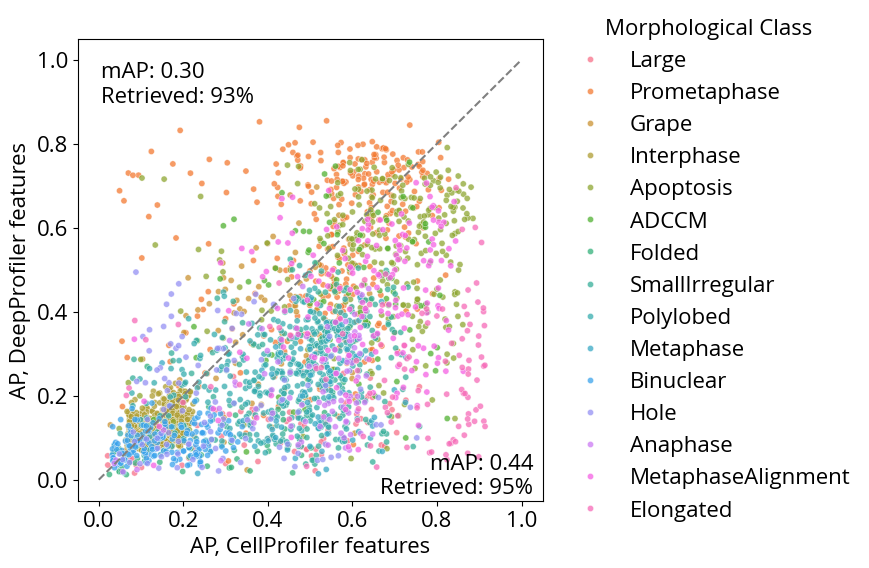

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
g = sns.scatterplot(
    ap_results_pivot_focus,
    x="AP, CellProfiler features",
    y="AP, DeepProfiler features",
    hue="Morphological Class", s=20, alpha=0.75, ax=ax)

g.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, title="Morphological Class", frameon=False)

ax.plot([0, 1], [0, 1], color='grey', linestyle='--')

ax.text(0.05, 0.95, f"mAP: {mean_aps['dp']:.2f}\nRetrieved: {retrieved['dp']:.0%}", transform=ax.transAxes, ha='left', va='top')  # Top left
ax.text(0.98, 0.005, f"mAP: {mean_aps['cp']:.2f}\nRetrieved: {retrieved['cp']:.0%}", transform=ax.transAxes, ha='right', va='bottom')



In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.boxenplot(
    data=ap_results.query("Mitocheck_Phenotypic_Class != 'OutOfFocus' and features != 'cp_dp'"),
    x="Mitocheck_Phenotypic_Class", y="average_precision", hue="features", fill=False, orient='h'
    )

KeyboardInterrupt: 

In [67]:
tech_map_compare = ap_results.query("features != 'cp_dp'").pivot(
    index="Mitocheck_Phenotypic_Class",
    columns="features",
    values="average_precision"
).reset_index()

ValueError: Index contains duplicate entries, cannot reshape

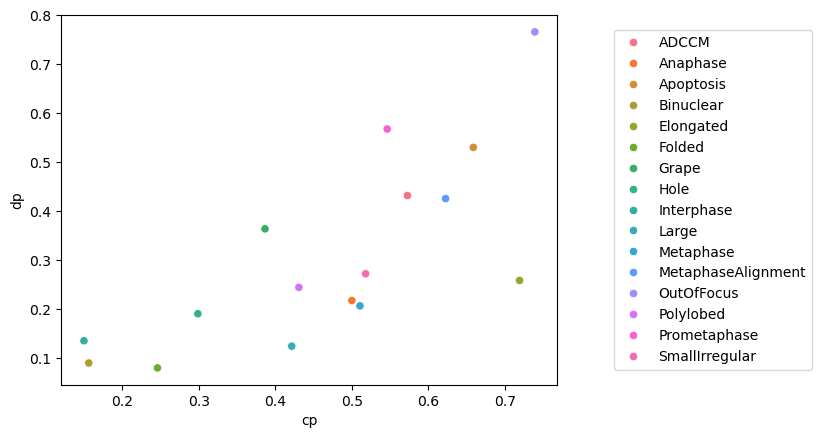

In [65]:
g = sns.scatterplot(tech_map_compare, x="cp", y="dp", hue="Mitocheck_Phenotypic_Class")
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

In [45]:
ap_result["p_value"] = p_values(ap_result, null_size=10000, seed=0)

  0%|          | 0/16 [00:00<?, ?it/s]

In [46]:
ap_result

,Mitocheck_Phenotypic_Class,Metadata_is_control,Cell_UUID,Location_Center_X,Location_Center_Y,Metadata_Plate,Metadata_Well,Metadata_Frame,Metadata_Site,Metadata_Plate_Map_Name,Metadata_DNA,Metadata_Gene,Metadata_Gene_Replicate,Metadata_control_index,n_pos_pairs,n_total_pairs,average_precision,p_value
0,Large,0,3ba3aae1-489a-4eae-87f5-f3c31c9c91e9,397,618,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.335984,0.0001
1,Large,0,c16d0e78-70db-49ff-bc48-027342fe00da,359,584,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.542653,0.0001
2,Large,0,4a6e4da9-941d-4a6c-968e-cb1932839313,383,685,LT0010_27,173,83,1,LT0010_27_173,LT0010_27/LT0010_27_173_83.tif,RAB21,1,-1,76,3976,0.178940,0.0001
3,Large,0,bd03dd73-f4fb-4a25-93ce-1720e55de69b,932,532,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.100909,0.0001
4,Large,0,9721f66a-6a76-4a22-a257-e021a5da9e01,479,110,LT0013_38,42,75,1,LT0013_38_42,LT0013_38/LT0013_38_42_75.tif,KIF14,1,-1,76,3976,0.136947,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,OutOfFocus,0,898c4f3a-08ab-4447-9307-ee4e56c02b53,383,219,LT0601_01,217,49,1,LT0601_01_217,LT0601_01/LT0601_01_217_49.tif,ABCB8,1,-1,303,4203,0.301878,0.0001
2890,OutOfFocus,0,777fb679-c278-4895-90a0-bf3f42873f58,975,293,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.295926,0.0001
2891,OutOfFocus,0,122e3161-b1b8-4ef3-908c-0dc898ce031f,899,302,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.632338,0.0001
2892,OutOfFocus,0,8bed4ad7-4634-41f5-a7eb-85da98a97e88,946,281,LT0603_03,2,49,1,LT0603_03_2,LT0603_03/LT0603_03_2_49.tif,failed QC,1,-1,303,4203,0.334689,0.0001


In [8]:
ap_result = map.average_precision(
    df[meta_features],
    df[cp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

map_result = map.mean_average_precision(
        ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map/lib/python3.12/site-packages/copairs/compute.py:110: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
map_result["features"] = "CP"
map_result

,Mitocheck_Phenotypic_Class,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,features
0,ADCCM,0.568623,0.0001,0.0001,True,True,CP
1,Anaphase,0.497724,0.0001,0.0001,True,True,CP
2,Apoptosis,0.658358,0.0001,0.0001,True,True,CP
3,Binuclear,0.155664,0.0001,0.0001,True,True,CP
4,Elongated,0.714324,0.0001,0.0001,True,True,CP
5,Folded,0.246021,0.0001,0.0001,True,True,CP
6,Grape,0.385644,0.0001,0.0001,True,True,CP
7,Hole,0.294037,0.0001,0.0001,True,True,CP
8,Interphase,0.149558,0.0001,0.0001,True,True,CP
9,Large,0.421420,0.0001,0.0001,True,True,CP


In [10]:
dp_ap_result = map.average_precision(
    df[meta_features],
    df[dp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

dp_map_result = map.mean_average_precision(
        dp_ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
)

dp_map_result["features"] = "DP"
dp_map_result

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
cp_dp_ap_result = map.average_precision(
    df[meta_features],
    df[cp_dp_features].values,
    pos_sameby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
    pos_diffby=[],
    # neg_sameby=["Metadata_Plate"],
    neg_sameby=[],
    neg_diffby=["Mitocheck_Phenotypic_Class", "Metadata_control_index"],
).query("Mitocheck_Phenotypic_Class != 'neg_control'").reset_index(drop=True)

cp_dp_map_result = map.mean_average_precision(
        cp_dp_ap_result, ["Mitocheck_Phenotypic_Class"], null_size=10000, threshold=0.05, seed=0
)

cp_dp_map_result["features"] = "CP_DP"
cp_dp_map_result

In [33]:
# storing all map results based on postiive and negative controls and feature types
logging.info("Running mAP pipeline with regular dataset")
map_results_neg_cp = []
map_results_neg_dp = []
map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # This will occur per phenotype
    for seed in range(0, n_resamples):
        # concatenate to positive and negative control
        # selecting around 0.015% of the control data, that's around 117 cells
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )

        # spliting metadata and raw feature values
        logging.info("splitting data set into metadata and raw feature values")
        negative_training_cp_meta, negative_training_cp_feats = utils.split_data(
            training_w_neg, dataset="CP"
        )
        negative_training_dp_meta, negative_training_dp_feats = utils.split_data(
            training_w_neg, dataset="DP"
        )
        negative_training_cp_dp_meta, negative_training_cp_dp_feats = utils.split_data(
            training_w_neg, dataset="CP_and_DP"
        )

        break

        # placing under "try" block as some phenotype may raise "DivisionByZeroError"
        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(f"Running pipeline on CP features using {phenotype} phenotype")

            feat_cols = [col for col in training_sc_data.columns if col not in negative_training_cp_meta.columns and not col.startswith("DP__")]
            cp_negative_training_result = calc_map(
                df=pd.concat([negative_training_cp_meta, pd.DataFrame(negative_training_cp_feats, columns=feat_cols)], axis=1).reset_index(drop=True),
                meta_features=negative_training_cp_meta.columns.tolist(),
                features=feat_cols,
                pair_config=pair_config,
                map_config=map_config
            )

            # cp_negative_training_result = run_pipeline(
            #     meta=negative_training_cp_meta,
            #     feats=negative_training_cp_feats,
            #     pos_sameby=pos_sameby,
            #     pos_diffby=pos_diffby,
            #     neg_sameby=neg_sameby,
            #     neg_diffby=neg_diffby,
            #     batch_size=batch_size,
            #     null_size=null_size,
            # )

            # adding columsn
            cp_negative_training_result["shuffled"] = "non-shuffled"
            cp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp.append(cp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(f"Running pipeline on DP features using {phenotype} phenotype")

            feat_cols = [col for col in training_sc_data.columns if col not in negative_training_dp_meta.columns and not col.startswith("CP__")]
            dp_negative_training_result = calc_map(
                df=pd.concat([negative_training_dp_meta, pd.DataFrame(negative_training_dp_feats, columns=feat_cols)], axis=1).reset_index(drop=True),
                meta_features=negative_training_dp_meta.columns.tolist(),
                features=feat_cols,
                pair_config=pair_config,
                map_config=map_config
            )

            # dp_negative_training_result = run_pipeline(
            #     meta=negative_training_dp_meta,
            #     feats=negative_training_dp_feats,
            #     pos_sameby=pos_sameby,
            #     pos_diffby=pos_diffby,
            #     neg_sameby=neg_sameby,
            #     neg_diffby=neg_diffby,
            #     batch_size=batch_size,
            #     null_size=null_size,
            # )

            # adding shuffle label column
            dp_negative_training_result["shuffled"] = "non-shuffled"
            dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_dp.append(dp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype"
            )

            feat_cols = [col for col in training_sc_data.columns if col not in negative_training_cp_dp_meta.columns]
            cp_dp_negative_training_result = calc_map(
                df=pd.concat([negative_training_cp_dp_meta, pd.DataFrame(negative_training_cp_dp_feats, columns=feat_cols)], axis=1).reset_index(drop=True),
                meta_features=negative_training_cp_dp_meta.columns.tolist(),
                features=feat_cols,
                pair_config=pair_config,
                map_config=map_config
            )

            # cp_dp_negative_training_result = run_pipeline(
            #     meta=negative_training_cp_dp_meta,
            #     feats=negative_training_cp_dp_feats,
            #     pos_sameby=pos_sameby,
            #     pos_diffby=pos_diffby,
            #     neg_sameby=neg_sameby,
            #     neg_diffby=neg_diffby,
            #     batch_size=batch_size,
            #     null_size=null_size,
            # )

            # adding shuffle label column
            cp_dp_negative_training_result["shuffled"] = "non-shuffled"
            cp_dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp_dp.append(cp_dp_negative_training_result)
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotye: {phenotype}. Skipping")
            continue


# concatenating all datasets
pd.concat(map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_regular_negcon.csv", index=False
)
pd.concat(map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_regular_negcon.csv", index=False
)
pd.concat(map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_regular_negcon.csv", index=False
)

ValueError: No objects to concatenate

## Running mAP Pipeline on regular dataset

In [ ]:
# storing all map results based on postiive and negative controls and feature types
logging.info("Running mAP pipeline with regular dataset")
map_results_neg_cp = []
map_results_neg_dp = []
map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # This will occur per phenotype
    for seed in range(0, n_resamples):
        # concatenate to positive and negative control
        # selecting around 0.015% of the control data, that's around 117 cells
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )

        # spliting metadata and raw feature values
        logging.info("splitting data set into metadata and raw feature values")
        negative_training_cp_meta, negative_training_cp_feats = utils.split_data(
            training_w_neg, dataset="CP"
        )
        negative_training_dp_meta, negative_training_dp_feats = utils.split_data(
            training_w_neg, dataset="DP"
        )
        negative_training_cp_dp_meta, negative_training_cp_dp_feats = utils.split_data(
            training_w_neg, dataset="CP_and_DP"
        )

        # placing under "try" block as some phenotype may raise "DivisionByZeroError"
        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(f"Running pipeline on CP features using {phenotype} phenotype")
            cp_negative_training_result = run_pipeline(
                meta=negative_training_cp_meta,
                feats=negative_training_cp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding columsn
            cp_negative_training_result["shuffled"] = "non-shuffled"
            cp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp.append(cp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(f"Running pipeline on DP features using {phenotype} phenotype")
            dp_negative_training_result = run_pipeline(
                meta=negative_training_dp_meta,
                feats=negative_training_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            dp_negative_training_result["shuffled"] = "non-shuffled"
            dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_dp.append(dp_negative_training_result)

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype"
            )
            cp_dp_negative_training_result = run_pipeline(
                meta=negative_training_cp_dp_meta,
                feats=negative_training_cp_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            cp_dp_negative_training_result["shuffled"] = "non-shuffled"
            cp_dp_negative_training_result["seed_val"] = seed

            # append to list
            map_results_neg_cp_dp.append(cp_dp_negative_training_result)
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotye: {phenotype}. Skipping")
            continue


# concatenating all datasets
pd.concat(map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_regular.csv", index=False
)
pd.concat(map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_regular.csv", index=False
)
pd.concat(map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_regular.csv", index=False
)

## Running MAP Pipeline with shuffled phenotype labels

In [ ]:
logging.info("Running mAP pipeline with shuffled phenotype labeled data")

# storing generated mAP pipline results seperated by feature
shuffled_labels_map_results_neg_cp = []
shuffled_labels_map_results_neg_dp = []
shuffled_labels_map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    logging.info(f"Phenotype selected: {phenotype}")
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # seed values will
    for seed in range(0, n_resamples):
        # setting seed
        logging.info(
            f"Running MAP Pipeline with shuffled data. Setting random seed too: {seed}"
        )
        np.random.seed(seed)

        # Below, we are running the same test, but we are shuffling the phenotypes
        logging.info(
            "Shuffling data based on the Mitocheck_Phenotypic_Class (phenotype) labels"
        )

        # concatenate to positive and negative control and shuffle labels
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )
        training_w_neg = shuffle_meta_labels(
            dataset=training_w_neg, target_col="Mitocheck_Phenotypic_Class", seed=seed
        )

        # splitting metadata labeled shuffled data
        logging.info("splitting shuffled data set into metadata and raw feature values")
        (
            shuffled_negative_training_cp_meta,
            shuffled_negative_training_cp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP")
        (
            shuffled_negative_training_dp_meta,
            shuffled_negative_training_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="DP")
        (
            shuffled_negative_training_cp_dp_meta,
            shuffled_negative_training_cp_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP_and_DP")

        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(
                f"Running pipeline on CP features using {phenotype} phenotype, data is shuffled by phenoptype labels"
            )
            shuffled_cp_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_meta,
                feats=shuffled_negative_training_cp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_negative_training_result["shuffled"] = "phenotype_shuffled"
            shuffled_cp_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_labels_map_results_neg_cp.append(
                shuffled_cp_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(
                f"Running pipeline on DP features using {phenotype} phenotype, data is shuffled by phenoptype labels"
            )
            shuffled_dp_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_dp_meta,
                feats=shuffled_negative_training_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_dp_negative_training_result["shuffled"] = "phenotype_shuffled"
            shuffled_dp_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_labels_map_results_neg_dp.append(
                shuffled_dp_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype, data is shuffled by phenoptype labels"
            )
            shuffled_cp_dp_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_dp_meta,
                feats=shuffled_negative_training_cp_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_dp_negative_training_result["shuffled"] = "phenotype_shuffled"
            shuffled_cp_dp_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_labels_map_results_neg_cp_dp.append(
                shuffled_cp_dp_negative_training_result
            )
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotye: {phenotype}. Skipping")
            continue

# saving to csv
pd.concat(shuffled_labels_map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_label_shuffled.csv", index=False
)
pd.concat(shuffled_labels_map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_label_shuffled.csv", index=False
)
pd.concat(shuffled_labels_map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_label_shuffled.csv", index=False
)

## Running MAP Pipeline with shuffled feature space 

In [ ]:
logging.info("Running mAP pipeline with shuffled feature space data")
shuffled_feat_map_results_neg_cp = []
shuffled_feat_map_results_neg_dp = []
shuffled_feat_map_results_neg_cp_dp = []

# running process
# for loop selects one single phenotype
# then splits the data into metadata and raw feature values
# two different groups that contains 3 splits caused by the types of features
# applie the copairs pipeline
for phenotype in list(training_sc_data["Mitocheck_Phenotypic_Class"].unique()):
    # select training dataset based on phenotype
    selected_training = training_sc_data.loc[
        training_sc_data["Mitocheck_Phenotypic_Class"] == phenotype
    ]
    n_entries_training = selected_training.shape[0]

    # This will generated 100 values [0..100] as seed values
    # seed values will
    for seed in range(0, n_resamples):
        # setting seed
        logging.info(
            f"Running MAP Pipeline with shuffled data. Setting random seed too: {seed}"
        )
        np.random.seed(seed)

        # Below, we are running the same test, but we are shuffling the phenotypes
        logging.info("Shuffling data based on the feature space")
        training_w_neg = pd.concat(
            [
                selected_training,
                neg_control_sc_data.sample(frac=0.010, random_state=seed).iloc[
                    :n_entries_training
                ],
            ]
        )

        # split the shuffled dataset
        # spliting metadata and raw feature values
        logging.info("splitting shuffled data set into metadata and raw feature values")
        (
            shuffled_negative_training_cp_meta,
            shuffled_negative_training_cp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP")
        (
            shuffled_negative_training_dp_meta,
            shuffled_negative_training_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="DP")
        (
            shuffled_negative_training_cp_dp_meta,
            shuffled_negative_training_cp_dp_feats,
        ) = utils.split_data(training_w_neg, dataset="CP_and_DP")

        # shuffling the features, this will overwrite the generated feature space from above with the shuffled one
        shuffled_negative_training_cp_feats = shuffle_features(
            feature_vals=shuffled_negative_training_cp_feats, seed=seed
        )
        shuffled_negative_training_dp_feats = shuffle_features(
            feature_vals=shuffled_negative_training_dp_feats, seed=seed
        )
        shuffled_negative_training_cp_dp_feats = shuffle_features(
            feature_vals=shuffled_negative_training_cp_dp_feats, seed=seed
        )

        try:
            # execute pipeline on negative control with trianing dataset with cp features
            logging.info(
                f"Running pipeline on CP features using {phenotype} phenotype, feature space is shuffled"
            )
            shuffled_cp_feat_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_meta,
                feats=shuffled_negative_training_cp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_feat_negative_training_result["shuffled"] = "features_shuffled"
            shuffled_cp_feat_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_feat_map_results_neg_cp.append(
                shuffled_cp_feat_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with dp features
            logging.info(
                f"Running pipeline on DP features using {phenotype} phenotype, feature space is shuffled"
            )
            shuffled_dp_feat_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_dp_meta,
                feats=shuffled_negative_training_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_dp_feat_negative_training_result["shuffled"] = "features_shuffled"
            shuffled_dp_feat_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_feat_map_results_neg_dp.append(
                shuffled_dp_feat_negative_training_result
            )

            # execute pipeline on negative control with trianing dataset with cp_dp features
            logging.info(
                f"Running pipeline on CP and DP features using {phenotype} phenotype, feature space is shuffled"
            )
            shuffled_cp_dp_feat_negative_training_result = run_pipeline(
                meta=shuffled_negative_training_cp_dp_meta,
                feats=shuffled_negative_training_cp_dp_feats,
                pos_sameby=pos_sameby,
                pos_diffby=pos_diffby,
                neg_sameby=neg_sameby,
                neg_diffby=neg_diffby,
                batch_size=batch_size,
                null_size=null_size,
            )

            # adding shuffle label column
            shuffled_cp_dp_feat_negative_training_result[
                "shuffled"
            ] = "features_shuffled"
            shuffled_cp_dp_feat_negative_training_result["seed_val"] = seed

            # append to list
            shuffled_feat_map_results_neg_cp_dp.append(
                shuffled_cp_dp_feat_negative_training_result
            )
        except ZeroDivisionError as e:
            logging.warning(f"{e} captured on phenotype: {phenotype}. Skipping")
            continue


# saving to csv
pd.concat(shuffled_feat_map_results_neg_cp).to_csv(
    map_out_dir / "cp_sc_mAP_scores_feat_shuffled.csv", index=False
)
pd.concat(shuffled_feat_map_results_neg_dp).to_csv(
    map_out_dir / "dp_sc_mAP_scores_feat_shuffled.csv", index=False
)
pd.concat(shuffled_feat_map_results_neg_cp_dp).to_csv(
    map_out_dir / "cp_dp_sc_mAP_scores_feat_shuffled.csv", index=False
)